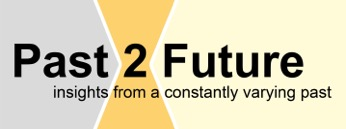

# Variability Figures

## 0. Introduction

This is a notebook that contains/makes some figures for a paper that is being written by Rehfeld et al. Please see the past2future.ipynb for some instructions about notebooks - as this one just gets straight down to business.

### Importing functions
Running the following cell, you are importing python required functions stored in the functions.py file in PMIP4_scripts. 

In [81]:
# press Enter + Shift to run coding cells
from scripts.functions import *
import xarray as xr
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import iris
from iris import load, Constraint
import iris.quickplot as qplt
import xesmf as xe


import warnings
warnings.filterwarnings("ignore")

## Ensemble averaging

This bit of code shold work out what files contain the required variable, so that they can be loaded in for ensemble averaging

In [10]:
def identify_ensemble_members(variable_name,experiment_name):
    datadir="~/data"
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict

In [18]:
files_A=identify_ensemble_members("nino34","midHolocene")
print(files_A[2])
model=extract_model_name(files_A[2])
print(model)

/data/p2f/cvdp_data/CNRM-CM5_midHolocene.cvdp_data.1950-2149.nc
CNRM-CM5


In [12]:
mh_dict=ensemble_members_dict("tas_spatialmean_ann","midHolocene")
ctl_dict=ensemble_members_dict("tas_spatialmean_ann","piControl")

for gcm in mh_dict:
    if gcm in ctl_dict:
        print("Need to load ", mh_dict.get(gcm))
        print("Then need to load ", ctl_dict.get(gcm))
        print("Take the difference of the two and interpolate them onto a standard grid")
        print(" ")

print("Having interpolated them all, we then need to ensemble average")


Need to load  /home/jovyan/data/AWI-ESM_midHolocene.cvdp_data.2801-2900.nc
Then need to load  /home/jovyan/data/AWI-ESM_piControl.cvdp_data.3004-3103.nc
Take the difference of the two and interpolate them onto a standard grid
 
Need to load  /home/jovyan/data/HadGEM3-GC31_midHolocene.cvdp_data.2250-2349.nc
Then need to load  /home/jovyan/data/HadGEM3-GC31_piControl.cvdp_data.2250-2349.nc
Take the difference of the two and interpolate them onto a standard grid
 
Need to load  /home/jovyan/data/IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc
Then need to load  /home/jovyan/data/IPSL-CM6A-LR_piControl.cvdp_data.1850-3049.nc
Take the difference of the two and interpolate them onto a standard grid
 
Having interpolated them all, we then need to ensemble average


In [57]:
varname="tas_spatialmean_ann"
mh_dict=ensemble_members_dict(varname,"midHolocene")
ctl_dict=ensemble_members_dict(varname,"piControl")
grid_1x1=xe.util.grid_global(1,1)

for gcm in mh_dict:
    if gcm in ctl_dict:
        expt_a_file=xr.open_dataset(mh_dict.get(gcm),decode_times=False)
        expt_a=expt_a_file.variables[varname]
        expt_b_file=xr.open_dataset(ctl_dict.get(gcm),decode_times=False)
        expt_b=expt_b_file.variables[varname]
        diff=expt_a-expt_b
        print('expt_a is %s, expt_b is %s and the difference is %s' % (expt_a.values[0,0],expt_b.values[0,0],diff.values[0,0]))
        this_regridder=xe.Regridder(diff,grid_1x1,'nearest_s2d', reuse_weights=True) 
        diff_1x1=this_regridder(diff)
        print(diff_1x1)
        print("Take the difference of the two and interpolate them onto a standard grid")
        print(" ")


expt_a is -50.347637, expt_b is -50.32548 and the difference is -0.022155762


TypeError: invalid indexer array, does not have integer dtype: array('lon', dtype='<U3')

[[-50.347637 -50.34976  -50.35081  ... -50.317616 -50.332375 -50.34215 ]
 [-49.04081  -49.118965 -49.187237 ... -48.665073 -48.814613 -48.93069 ]
 [-48.25056  -48.348587 -48.408638 ... -47.681484 -47.908714 -48.099003]
 ...
 [-17.337662 -17.215439 -17.102314 ... -17.737291 -17.601421 -17.462711]
 [-17.76464  -17.725807 -17.685852 ... -17.896383 -17.849916 -17.806637]
 [-18.100046 -18.095299 -18.090702 ... -18.108234 -18.104961 -18.102001]]
[[-0.02215576171875 -0.023059844970703125 -0.024112701416015625 ...
  -0.02771759033203125 -0.0280609130859375 -0.0286712646484375]
 [-0.13114166259765625 -0.11291885375976562 -0.10400390625 ...
  -0.16098403930664062 -0.156585693359375 -0.13969039916992188]
 [-0.10401535034179688 -0.08675384521484375 -0.0750732421875 ...
  -0.14040374755859375 -0.11959075927734375 -0.10711288452148438]
 ...
 [-0.4990959167480469 -0.5001239776611328 -0.5042304992675781 ...
  -0.5075492858886719 -0.5046539306640625 -0.4982166290283203]
 [-0.5240802764892578 -0.5227146

ValueError: 'bboxes' cannot be empty

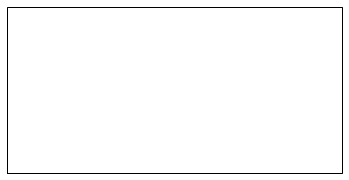

In [100]:
varname="tas_spatialmean_ann"
variable_constraint = Constraint(cube_func=(lambda c: c.var_name == varname))
mh_dict=ensemble_members_dict(varname,"midHolocene")
ctl_dict=ensemble_members_dict(varname,"piControl")
grid_target=iris.load(mh_dict.get("AWI-ESM"),variable_constraint)
average=grid_target[0]
print(average.data)
n=0
for gcm in mh_dict:
    if gcm in ctl_dict:
        expt_a=iris.load(mh_dict.get(gcm),variable_constraint)
        expt_b=iris.load(ctl_dict.get(gcm),variable_constraint)
        diff=expt_a[0] - expt_b[0]
        #print('expt_a is %s, expt_b is %s and the difference is %s' % (expt_a[0].data,expt_b[0].data,diff[0].data))
        diff_target=diff.regrid(grid_target[0], iris.analysis.Linear())
        print(diff_target.data)
        weighted=average.data*n
        average.data=np.add(weighted,diff_target.data)
        average.data=average.data/(n+1)
        print(average.data)
        n=n+1
        

print(average.data)        
iris.plot.contourf(average,levels=np.arange(-5,5,1),extend='both')

In [99]:
varname="tas_spatialmean_ann"
variable_constraint = Constraint(cube_func=(lambda c: c.var_name == varname))
mh_dict=ensemble_members_dict(varname,"midHolocene")
ctl_dict=ensemble_members_dict(varname,"piControl")
grid_target=iris.load(mh_dict.get("AWI-ESM"),variable_constraint)
average=grid_target[0]
print(average.data)
n=0
gcm="IPSL-CM6A-LR"
expt_a=iris.load(mh_dict.get(gcm),variable_constraint)
expt_b=iris.load(ctl_dict.get(gcm),variable_constraint)
diff=expt_a[0] - expt_b[0]
diff_target=diff.regrid(grid_target[0], iris.analysis.Linear())
print(diff_target.data)
weighted=average.data*n
print(weighted)
average.data=np.add(weighted,diff_target.data)
print(average.data)
average.data=average.data/(n+1)
print(average.data)        

[[-50.347637 -50.34976  -50.35081  ... -50.317616 -50.332375 -50.34215 ]
 [-49.04081  -49.118965 -49.187237 ... -48.665073 -48.814613 -48.93069 ]
 [-48.25056  -48.348587 -48.408638 ... -47.681484 -47.908714 -48.099003]
 ...
 [-17.337662 -17.215439 -17.102314 ... -17.737291 -17.601421 -17.462711]
 [-17.76464  -17.725807 -17.685852 ... -17.896383 -17.849916 -17.806637]
 [-18.100046 -18.095299 -18.090702 ... -18.108234 -18.104961 -18.102001]]
[[-0.033505331724882126 -0.03193620964884758 -0.03158939257264137 ...
  -0.033799558877944946 -0.03226806968450546 -0.03179068863391876]
 [-0.027676625177264214 -0.02840699814260006 -0.02788003534078598 ...
  -0.030511468648910522 -0.029814574867486954 -0.029034702107310295]
 [-0.006090184208005667 -0.007011933717876673 -0.005051285494118929 ...
  -0.014111836440861225 -0.011306357569992542 -0.007412663660943508]
 ...
 [0.05933461710810661 0.05218326672911644 0.04574031010270119 ...
  0.08427653461694717 0.07475825399160385 0.06645964831113815]
 [0.0

## Scatter Plots 

### Read in data
These scripts make use of the fact that as well as the individual model files there are some mode and ipcc timeseries variables extracted using NCL and sitting in the ~/data directory. This does curtail which plots are possible, but makes them easier and forces me to practice python.

In [2]:
ipcc_filename = 'data/ipcc_region_array.nc'
ipcc_dataset = xr.open_dataset(ipcc_filename)
ipcc=ipcc_dataset.ipcc_region_array
print(ipcc.timeseries)

<xarray.DataArray 'timeseries' (timeseries: 96)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95])
Dimensions without coordinates: timeseries
